# PA 2.7: Times Tables

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 2.7. Due: complete this PA prior to class on Friday, Jan 10, 2025.*

_Note: this notebook is long, but the work required is quite simple. It is meant to serve as a reference for when you are applying Pandas and formatted tables in the future, both during MUDE and after!_

## Overview

In this assignment we will continue our Pandas journey by learning how to process and use time series data, which is a primary reason that this library is so useful. We will combine this with a brief tour of a few different ways to format information in tables using Markdown and Python.

Remember that we introduced the Pandas library in PA 2.5. You should spend a few minutes reviewing PA 2.5 if you can't recall the following key concepts:

1. Pandas core functionality relies on two objects `DataFrame` and `Series`
2. A dictionary-like syntax is used to access data, e.g., `df['key']` returns values
3. You can use the attribute `values` to access the data in a `Series`, e.g., `df['key'].values`
4. We used (but did not explain) the method `loc` to find the "rows" of the DataFrame subject to certain criteria, e.g., see Task 0.2 of PA15
5. Import and export carried out with `read_csv` and `to_csv` methods
6. A few methods for exploring the data set once imported into a notebook, e.g., `describe()` or `head()`

In this assignment we will add the following to our repertoire:
1. See one example of how to address date and time data in a way that makes it "easy" for Pandas to interpret it
2. Extract maximum values within a set period of interest using `groupby`; specifically, the maximum value observed in each month
3. Extract maximum values that are defined by a threshold and with a minimum separation in time using `scipy.find_peaks`

_Items 2 and 3 above are key for block maxima and peak over threshold methods used in Extreme Value Analysis; the focus is on understanding the syntax and process of what is happening rather than implementing the entire workflow yourself from scratch._

After this programming assignment, our journey with Pandas in MUDE ends. Note that we only scratched the surface in terms of capabilities, focusing on fundamental data types and a few simple operations, along with pre-processed data sets that are easy to handle. If you find yourself dealing with unprocessed data in the future, especially if a time series, consider using Pandas; there are many free tutorials available online.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
plt.rcParams.update({'font.size': 14})

## Task 0: Download, Import and Interpret the Data Set

<div style="background-color:#AABAB2; color: black; width: 95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 0.1:</b>   
    
Complete the code cell below to import the data. Use the commented lines of code to interpret the contents.
</p>
</div>

In [2]:
# h = pd.read_csv(YOUR_CODE_HERE, delimiter=';', header=3)
# Solution
h = pd.read_csv('data.csv', delimiter=';', header=3)

h.columns=['Date', 'Stage']
# h.describe()
# h.head()
# h['Date']

As you may have already guessed, this data set is from a river in California; it measures river stage in feet (what a strange unit!) over the 2023 _water year._ A water year starts on October 1 and runs through September 30 of the following calendar year; it is a convenient way of capturing the wet season, which typically occur during the winter months.

_Note that the river has a cool name that is actually the namesake of a taseful California brand commonly available at watering holes in Europe ever since purchased by a well-known (inferior!) Dutch brand...if you are one of the first few students to tell Robert the correct explanation of this strange note he will give you a prize._

Unfortunately we can't create a plot to visualize the data with the `Date` information becaues `matplotlib` doesn't know how to interpret the value. Luckily there are easy ways to address this, two of which are illustrated in Task 1.

## Task 1: Use Pandas to Plot the Time Series with `datetime`

The Pandas method is `datetime`, which converts the object type from a generic (un-usable-for-plotting) data type ito a `datetime` type. A full explanation of this is outside the scope of MUDE, so we simply illustrate it below. For our purposes, note that:
- the `datetime` object created by `to_datetime` is a significant improvement on the standard Python functionality
- Pandas provides a _lot_ of methods that can use it (we only scratch the surface here)
- to learn more, if you are interested, there is plenty available online, like the tutorial [here](https://www.dataquest.io/blog/datetime-in-pandas/)


<div style="background-color:#AABAB2; color: black; width: 95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.1:</b>   
    
Study the code cell below to see how to create a <code>datetime</code> object. Note in particular the <code>dtype</code> printed in the Pandas output, indicating the method was successful.
</p>
</div>

In [3]:
h['Date'] = pd.to_datetime(h['Date'], format='%d-%m-%Y %H:%M')
h['Date']

0       2022-10-01 00:00:00
1       2022-10-01 00:15:00
2       2022-10-01 00:30:00
3       2022-10-01 00:45:00
4       2022-10-01 01:00:00
                ...        
34193   2022-09-30 23:00:00
34194   2022-09-30 23:30:00
34195   2022-09-30 23:00:00
34196   2022-09-30 23:30:00
34197   2022-09-30 23:15:00
Name: Date, Length: 34198, dtype: datetime64[ns]

<div style="background-color:#AABAB2; color: black; width: 95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1.2:</b>   
    
Now you can run the cell below to visualize the hydrograph! Note the peaks that occurred during this water year, which correspond to storm events that occurred. Imagine you are interested in evaluating the flood hazard in this river,then try to think about how you might try to extract what those values are using Python (but don't actually do it; that's the next two tasks!).
</p>
</div>

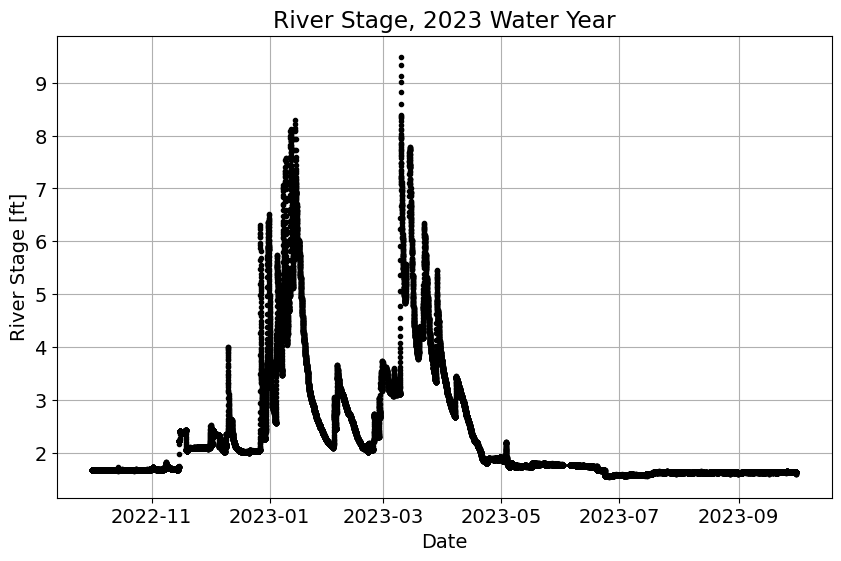

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(h['Date'], h['Stage'],'k.')
plt.xlabel('Date')
plt.ylabel('River Stage [ft]')
plt.grid()
plt.title('River Stage, 2023 Water Year');

## Task 2: Finding Peak Values (2 methods)

You may have struggled to imagine how to extract the maximum values, besides simply trying a method like `h['Stage'].values.max()`. We will help you out here. First, we will show you a useful method `groupby`, which uses the `datetime` object to easily get the maximum value that occurred in each month.

<div style="background-color:#AABAB2; color: black; width: 95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.1:</b>   
    
Read the code cell below and explore using it until you understand what is happening (hint: here is where you may need to review that previous PA on Pandas). Then modify the code cell to extract the <em>monthly</em> maxima instad of the yearly maxima.
</p>
</div>

In [5]:
# idx_max = h.groupby(pd.DatetimeIndex(h['Date']).year)['Stage'].idxmax()

# Solution
idx_max = h.groupby(pd.DatetimeIndex(h['Date']).month)['Stage'].idxmax()

h.loc[idx_max]

,Date,Stage
10123,2023-01-14 09:45:00,8.30
14452,2023-02-28 12:00:00,3.74
15373,2023-03-10 02:15:00,9.49
17291,2023-04-01 00:45:00,3.55
20334,2023-05-03 11:30:00,2.20
22882,2023-06-01 11:15:00,1.79
27345,2023-07-21 15:00:00,1.66
29464,2023-08-12 16:45:00,1.65
34193,2022-09-30 23:00:00,1.67
1314,2022-10-14 16:30:00,1.73


<div style="background-color:#AABAB2; color: black; width: 95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.2:</b>   
    
Complete the code cell below to plot the monthly maximum values.
</p>
</div>

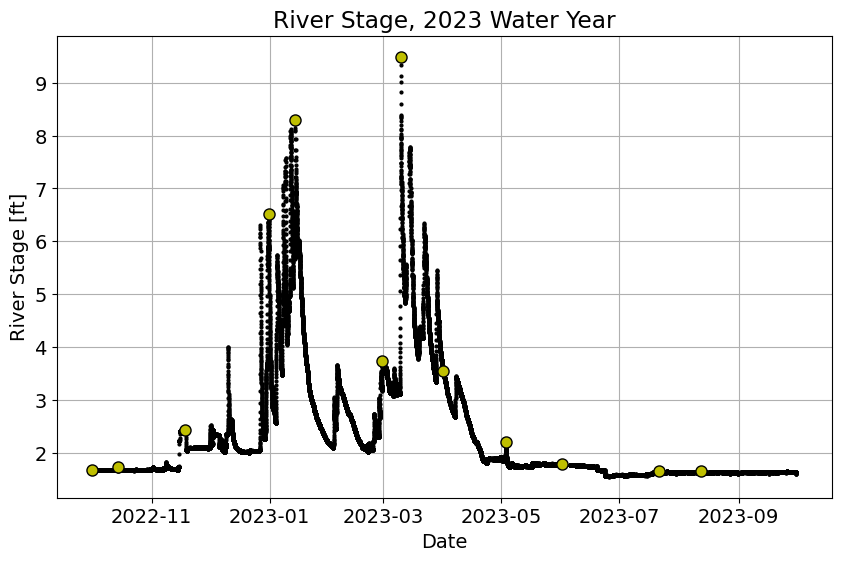

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(h['Date'], h['Stage'],'k.', markersize=4)
plt.xlabel('Date')
plt.ylabel('River Stage [ft]')
plt.grid()
plt.title('River Stage, 2023 Water Year')
# plt.plot(h[YOUR_CODE_HERE][YOUR_CODE_HERE], h[YOUR_CODE_HERE][YOUR_CODE_HERE], 'y.', markersize=16, markeredgecolor='k')
# Solution:
plt.plot(h['Date'][idx_max], h['Stage'][idx_max], 'y.', markersize=16, markeredgecolor='k');

As you may have noticed, **this does not find all of the biggest maxima!** We need another method.

We can use the scipy method `find_peaks` to help get the "true" maximum value of each storm event. It requires two additional arguments:
- `height` can specify a lower bound, above which to consider, and 
- `distance` makes sure that all peaks are separated by a minimum amount

_Note that the_ `one_day` _variable defines the duration of 24 hours as the number of data points, which are spaced 15-minutes apart._

<div style="background-color:#AABAB2; color: black; width: 95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2.3:</b>   
    
The code cell below is set up with an initial set of parameters, along with a print and figure summary of the results. Alter the arguments to try and match the most significant flood events in the data set. Note that the answer is subjective; try to get around 10 of the biggest values.
</p>
</div>

                      Date      Stage
count                   10  10.000000
mean   2023-02-04 15:49:30   6.592000
min    2022-12-27 06:15:00   4.350000
25%    2023-01-06 01:45:00   5.767500
50%    2023-01-16 10:07:30   6.330000
75%    2023-03-14 07:52:30   7.312500
max    2023-03-28 13:15:00   9.490000
std                    NaN   1.492558


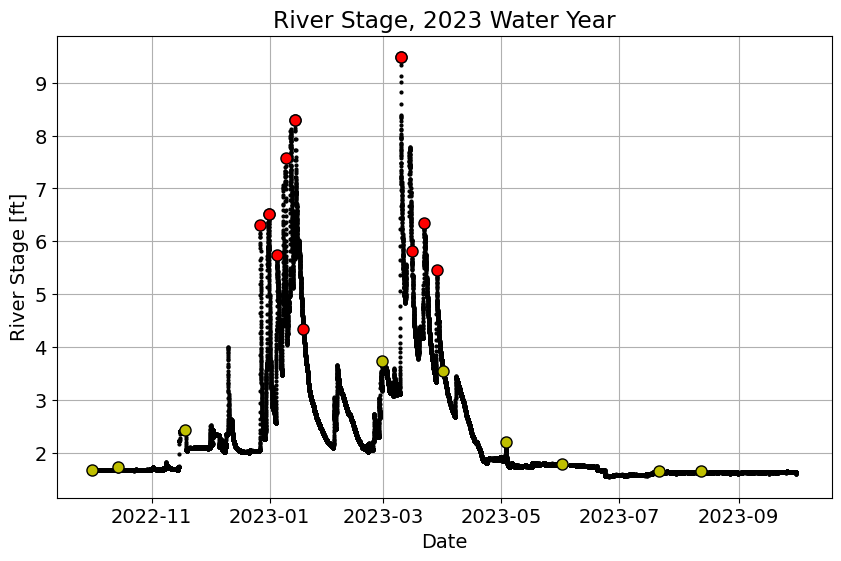

In [7]:
one_day = 4*24
# idx_peaks, _ = find_peaks(h['Stage'], height=1.0, distance=one_day)
# Solution:
idx_peaks, _ = find_peaks(h['Stage'], height=4.2, distance=4*one_day)

print(h.loc[idx_peaks].describe())

plt.figure(figsize=(10, 6))
plt.plot(h['Date'], h['Stage'],'k.', markersize=4)
plt.xlabel('Date')
plt.ylabel('River Stage [ft]')
plt.grid()
plt.title('River Stage, 2023 Water Year')
plt.plot(h['Date'][idx_max], h['Stage'][idx_max],'y.', markersize=16, markeredgecolor='k')
plt.plot(h['Date'][idx_peaks], h['Stage'][idx_peaks],'r.', markersize=16, markeredgecolor='k');

That's it for Pandas for now. In the next section we will learn about formatted tables, then practice using the tables by present the results of our peaks analysis.

## Task 3: Summarizing Results in Formatted Tables

It is handy to be able to summarize key numerical results in tables; especially when working with different probability models, as we will do this week when comparing extreme value distributions. This section will show you how to do this in a simple way, using the peak river stage data found above as an example.

First, an explanation of the methods (1 using Markdown, 2 using Python).

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>Yes, we know you learned about Markdown tables in Q1. We decided to repeat it again here, since it is such a useful skill to have!</p></div>

<div style="background-color:#AABAB2; color: black; width: 95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.1:</b>   
    
Read through the explanation below; try to explore the Markdown and Python cells as you go (they will all run without error), as you will be asked to apply the formatting table methods in Tasks 3.2-3.4 (one table method each).
</p>
</div>

### Formatting Tables in Markdown

This is relatively straightforward, once you learn the proper syntax. Note, however, that the most challenging thing about Markdown tables (and Markdown in general) is that every platform interprets the source code (i.e., the text) differently---in other words, what works in Jupyter may not work the same in VS Code (and Deepnote is almost always different). Fortunately this is usually fixed with a little trial-and-error, usually with white space (spaces, new lines, etc) or a quick Google search for some example code.

The following are key notes for constructing a table:
- The essential element is the pipe symbol `|` (the vertical bar), which denotes the column boundaries.
- Each line of code is a new row in the table, which will generate automatically in a Markdown cell as long as you have the same number of pipes in each row.
- The second row is essential, and must contain at least one colon `:` and one hyphen (dash) `-` that tells the Markdown interpreter that you are defining a table (see next comment, and examples).
- You can specify left, center or right justification of text in each column using `:-`, `:-:` or `-:`, respectively. You can also use extra hyphens or whitespace to format the raw text in a readable way.

Below are four example tables to illustrate how it works, the first two displayed in a Markdown cell, then a raw code cell

_Table 1: Example table, empty; formatted as source code._

```
|     |     |     |
| :-: | :-: | :-: |
|     |     |     |
```

_Table 2: Example with left, center, right justification in columns._

| Column 1 | Column 2 | Column 3 |
| :- | :-: | -: |
| Left Justified | Center | Right |
| a | b | c |
| 1 | 2 | 3 |


Note that you have limited options in Markdown for advanced formatting, for example, color, non-bold header row or positioning of the entire table on the left or right of the page. But that's OK: the example above is sufficient to share the information in your table effectively, which is sufficient for MUDE. If you really want to customize your tables more precisely, it would be more efficient to do so using HTML.

### Formatting Tables with Python (2 Methods)

The easiest way to make a table is with formatted strings; we include two methods here, based on the following generic syntax for printing a variable with 3 significant digits.

1. `f'My string with values x = {VALUE:FORMAT} and y = {VALUE:FORMAT}.'`
2. `'My string with values x = {FORMAT} and y = {FORMAT}.format(VALUE, VALUE)'`



In [8]:
x = 1.24196854
y = 2
string_1 = f'My string with values x = {x:0.3f} and y = {y:0.3f}'
string_2 = 'My string with values x = {:0.3f} and y = {:0.3f}'.format(x, y)
print(string_1)
print(string_2)

My string with values x = 1.242 and y = 2.000
My string with values x = 1.242 and y = 2.000


For method 2, the index of the value in the arguments of `format()` can be optionally specified as `{INDEX:VALUE}`, illustrated below (also with a second example which shows tuple unpacking `*`, cool!!!)":

In [9]:
print('Second argument is {1:0.3f} and first argument is {0:0.3f}'.format(x, y))

def square(z1, z2):
    'Return tuple with squared values of 2 inputs.'
    return z1*z1, z2*z2

print('Second argument of squared values is {1:0.3f} and first is {0:0.3f}'.format(*square(x,y)))

Second argument is 2.000 and first argument is 1.242
Second argument of squared values is 4.000 and first is 1.542


Note that the examples above used the `.3f` format specifier to represent a float, where the `.3` specifies the number of decimal places. The optional (and missing) value to the left of the `.` specifies the _total_ width to make print the string.

In [10]:
print(f'{5:7.3f}')
print('^^^^^^^')
print('|||||||')
print('1234567 total width')
print('    123 total decimals')

  5.000
^^^^^^^
|||||||
1234567 total width
    123 total decimals


Note that the width is more of a minimum, as the string will take more space if the decimal demands it:

In [11]:
print(f'{5:7.3f}  <-- same example as above')
print('^^^^^^^')
print('|||||||')
print('1234567 total width')
print(f'{5:1.3f}  <-- total width exceeded; no white space to left of integer')
print('^')
print('|')
print('1 total width (exceeded)')

  5.000  <-- same example as above
^^^^^^^
|||||||
1234567 total width
5.000  <-- total width exceeded; no white space to left of integer
^
|
1 total width (exceeded)


<div style="background-color:#AABAB2; color: black; width: 95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.1 ... AGAIN:</b>   
    
Have you been reading and exploring? I bet not...go back up and do it again, it's good for you!
</p>
</div>

There are a variety of formatting types, for example:

- `f` is a floating point decimal (illustrated above)
- `e` is a scientific notation decimal (specify two numbers, `X` and `Y`, similar to `f`: `:X.Ye`)
- `d` is an integer (only on number needed, `X`: `:Xd`

In each case, the number `X` specifies the max width printed. Here are a few examples:

In [12]:
print('123456789 <-- try printing things with 9 spaces')
print(f'{5:9.3f}')
print(f'{5:9.3e}')
print(f'{5.516654654654:9.9f} <-- oops, f overflowed')
print(f'{5.516654654654:9.9e} <-- e did also')
print(f'{5.516654654654:9.2f} <-- oops, f overflowed')
print(f'{5.516654654654:9.2e} <-- but e did not!')
print(f'{5:9d}')
print(f'{5651651651654:9d} <-- decimal overflow')
string_a = '5'
string_b = '5651651651654'
print(f'{string_a:9s} <-- string left justified')
print(f'{string_b:9s} <-- string overflow')

123456789 <-- try printing things with 9 spaces
    5.000
5.000e+00
5.516654655 <-- oops, f overflowed
5.516654655e+00 <-- e did also
     5.52 <-- oops, f overflowed
 5.52e+00 <-- but e did not!
        5
5651651651654 <-- decimal overflow
5         <-- string left justified
5651651651654 <-- string overflow


These letters (`f`, `e`, `d` and `s`) are called _conversion types_: you can find out more about them in the [Python documentation here](https://docs.python.org/3/library/stdtypes.html#printf-style-string-formatting).

To use these strings effectively to make tables, you can use the max width value to enforce a uniform column width, then add a header row to suit your fancy. Just remember to specify a value that is as large as the longest string value you expect.

Here is an example with an f-string, where the pipe symbols are included only for aesthetics, and the (arbitrary) column space is 10 characters:

In [13]:
print('| Column 1 | Column 2 | Column 3 |')
print('| -------- | -------- | -------- |')
print(f'|{0.5:10.3f}|{2.5:10.3f}|{1.5:10f}|')
print(f'|{0.5:10.3f}|{0.5:10.3e}|{2:10d}|')
print(f'|{3:10d}|{0.5:10f}|{0.5:10f}|')

| Column 1 | Column 2 | Column 3 |
| -------- | -------- | -------- |
|     0.500|     2.500|  1.500000|
|     0.500| 5.000e-01|         2|
|         3|  0.500000|  0.500000|


You can also specify alignment with `<` or `>`!

In [14]:
print('| Column 1 | Column 2 | Column 3 |')
print('| -------- | -------- | -------- |')
print(f'|{0.5:<10.3f}|{2.5:<10.3f}|{1.5:<10f}|')
print(f'|{0.5:<10.3f}|{0.5:<10.3e}|{2:<10d}|')
print(f'|{3:<10d}|{0.5:<10f}|{0.5:<10f}|')

| Column 1 | Column 2 | Column 3 |
| -------- | -------- | -------- |
|0.500     |2.500     |1.500000  |
|0.500     |5.000e-01 |2         |
|3         |0.500000  |0.500000  |


As you can see, this is pretty straightforward, but if the values in the curly braces start to get long, things get messy. Here is the same example with each value squared; hard to read, right?

In [15]:
print('| Column 1 | Column 2 | Column 3 |')
print('| -------- | -------- | -------- |')
print(f'|{0.5**2:10.3f}|{2.5**2:10.3f}|{1.5**2:10f}|')
print(f'|{0.5**2:10.3f}|{0.5**2:10.3e}|{2**2:10d}|')
print(f'|{3**2:10d}|{0.5**2:10f}|{0.5**2:10f}|')

| Column 1 | Column 2 | Column 3 |
| -------- | -------- | -------- |
|     0.250|     6.250|  2.250000|
|     0.250| 2.500e-01|         4|
|         9|  0.250000|  0.250000|


**This is where the `.format()` method comes in!** It is useful for making the code more readable; here is the same example with the alternative method:

In [16]:
print('| Column 1 | Column 2 | Column 3 |')
print('| -------- | -------- | -------- |')
print('|{:10.3f}|{:10.3f}|{:10f}|'.format(0.5**2, 2.5**2, 1.5**2))
print('|{:10.3f}|{:10.3e}|{:10d}|'.format(0.5**2, 0.5**2, 2**2))
print('|{:10d}|{:10f}|{:10f}|'.format(3**2, 0.5**2, 0.5**2))

| Column 1 | Column 2 | Column 3 |
| -------- | -------- | -------- |
|     0.250|     6.250|  2.250000|
|     0.250| 2.500e-01|         4|
|         9|  0.250000|  0.250000|


This is much easier to "read" the table structure, right?! 

That's it for now on tables---hopefully you can use these simple methods in your daily workflow to interpret your analyses more effectively and efficiently; especially if you refer back to them at a later date.

[This page](https://realpython.com/python-string-formatting/) is an excellent reference if you desire more background information or examples with string formatting.

_Note: there are many packages available to format tables in Python which you are welcome to explore (e.g., [this one](https://www.pytables.org/) or [this one](https://pypi.org/project/great-tables/)); however, the basic functionality of formatted strings is more than sufficient for simple data summaries._

<div style="background-color:#AABAB2; color: black; width: 95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.2:</b>   
    
Using the cell below, create a Markdown table summarizing the peaks you found at the end of Task 1. The table should be 2 columns by N rows (where N is the number of peaks you found).
</p>
</div>

`YOUR_Markdown_HERE`

<div style="background-color:#AABAB2; color: black; width: 95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.3:</b>   
    
Using the cell below, create a Python table summarizing the peaks you found at the end of Task 1 using the f-string method. The table should be 2 columns by N rows (where N is the number of peaks you found).
</p>
</div>

In [17]:
# YOUR_CODE_HERE

<div style="background-color:#AABAB2; color: black; width: 95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3.4:</b>   
    
Using the cell below, create a Python table summarizing the peaks you found at the end of Task 1 using the <code>.format()</code> method. The table should be 2 columns by N rows (where N is the number of peaks you found).
</p>
</div>

In [18]:
# YOUR_CODE_HERE

**End of notebook.**

<div style="margin-top: 50px; padding-top: 20px; border-top: 1px solid #ccc;">
  <div style="display: flex; justify-content: flex-end; gap: 20px; align-items: center;">
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="width:100px; height:auto;" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="width:100px; height:auto;" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" />
    </a>
    <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">
      <img alt="Creative Commons License" style="width:88px; height:auto;" src="https://i.creativecommons.org/l/by/4.0/88x31.png" />
    </a>
  </div>
  <div style="font-size: 75%; margin-top: 10px; text-align: right;">
    By <a rel="MUDE" href="http://mude.citg.tudelft.nl/">MUDE Team</a>
    &copy; 2024 TU Delft. 
    <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">CC BY 4.0</a>.
    <a rel="Zenodo DOI" href="https://doi.org/10.5281/zenodo.16782515"><img style="width:auto; height:15; vertical-align:middle" src="https://zenodo.org/badge/DOI/10.5281/zenodo.16782515.svg" alt="DOI https://doi.org/10.5281/zenodo.16782515"></a>
  </div>
</div>


<!--tested with WS_2_8_solution.ipynb-->